In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-age/face_age/057/6802.png
/kaggle/input/facial-age/face_age/057/3702.png
/kaggle/input/facial-age/face_age/057/8810.png
/kaggle/input/facial-age/face_age/057/6759.png
/kaggle/input/facial-age/face_age/057/1846.png
/kaggle/input/facial-age/face_age/057/7216.png
/kaggle/input/facial-age/face_age/057/3028.png
/kaggle/input/facial-age/face_age/057/5568.png
/kaggle/input/facial-age/face_age/057/5630.png
/kaggle/input/facial-age/face_age/057/3444.png
/kaggle/input/facial-age/face_age/057/6700.png
/kaggle/input/facial-age/face_age/057/4238.png
/kaggle/input/facial-age/face_age/057/3157.png
/kaggle/input/facial-age/face_age/057/7962.png
/kaggle/input/facial-age/face_age/057/8462.png
/kaggle/input/facial-age/face_age/057/9503.png
/kaggle/input/facial-age/face_age/057/3241.png
/kaggle/input/facial-age/face_age/057/4629.png
/kaggle/input/facial-age/face_age/057/8075.png
/kaggle/input/facial-age/face_age/057/891.png
/kaggle/input/facial-age/face_age/057/5275.png
/kaggle/input/

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, mean_squared_error
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:

base_path = '/kaggle/input/facial-age/face_age/'
image_folders = os.listdir(base_path)

# print(image_folders)

age_labels = []
gender_labels = []
image_paths = []
image_names = []

for dir_name in image_folders:
    dir_path = os.path.join(base_path, dir_name)
    image_files = os.listdir(dir_path)
    for img in image_files:
        try:
            age = int(dir_name)
            age_labels.append(age)
            image_names.append(img)
            image_paths.append(os.path.join(base_path,dir_name,img))
        except Exception as e:
            # the dataset folder has another folder with the dataset itself: This will prevent that folder from joining the df
            continue
            

df = pd.DataFrame({
    'image_path': image_paths,
    'image_name': image_names,
    'age': age_labels
})

df

,image_path,image_name,age
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,57
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,57
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,57
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,57
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,57
...,...,...,...
9773,/kaggle/input/facial-age/face_age/085/7733.png,7733.png,85
9774,/kaggle/input/facial-age/face_age/085/3123.png,3123.png,85
9775,/kaggle/input/facial-age/face_age/085/5302.png,5302.png,85
9776,/kaggle/input/facial-age/face_age/085/9632.png,9632.png,85


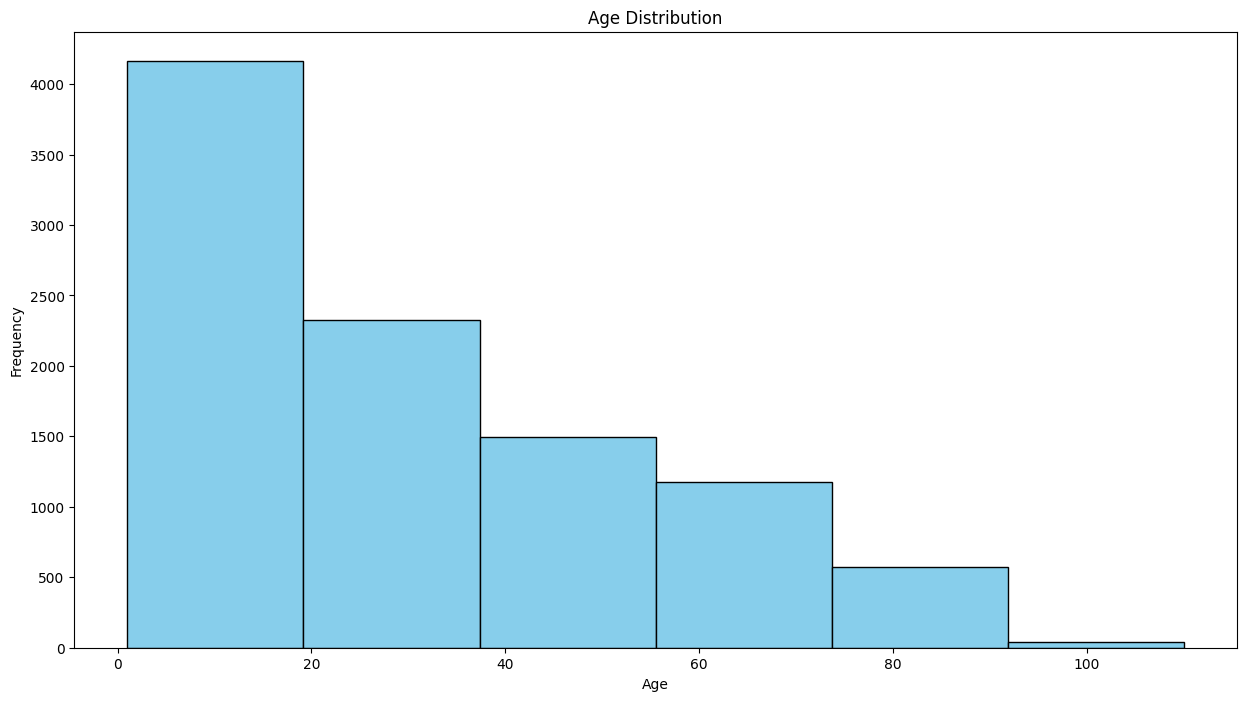

In [4]:
plt.figure(figsize=(15, 8))
plt.hist(df['age'], bins=6, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()


In [5]:
df['Age_Group'] = pd.qcut(df['age'], q=4, labels=range(0,4))
df['Age_Interval'] = pd.qcut(df['age'], q=4)

df

,image_path,image_name,age,Age_Group,Age_Interval
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,57,3,"(49.0, 110.0]"
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,57,3,"(49.0, 110.0]"
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,57,3,"(49.0, 110.0]"
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,57,3,"(49.0, 110.0]"
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,57,3,"(49.0, 110.0]"
...,...,...,...,...,...
9773,/kaggle/input/facial-age/face_age/085/7733.png,7733.png,85,3,"(49.0, 110.0]"
9774,/kaggle/input/facial-age/face_age/085/3123.png,3123.png,85,3,"(49.0, 110.0]"
9775,/kaggle/input/facial-age/face_age/085/5302.png,5302.png,85,3,"(49.0, 110.0]"
9776,/kaggle/input/facial-age/face_age/085/9632.png,9632.png,85,3,"(49.0, 110.0]"


In [6]:
df['Age_Interval'].unique()

[(49.0, 110.0], (25.0, 49.0], (7.0, 25.0], (0.999, 7.0]]
Categories (4, interval[float64, right]): [(0.999, 7.0] < (7.0, 25.0] < (25.0, 49.0] < (49.0, 110.0]]

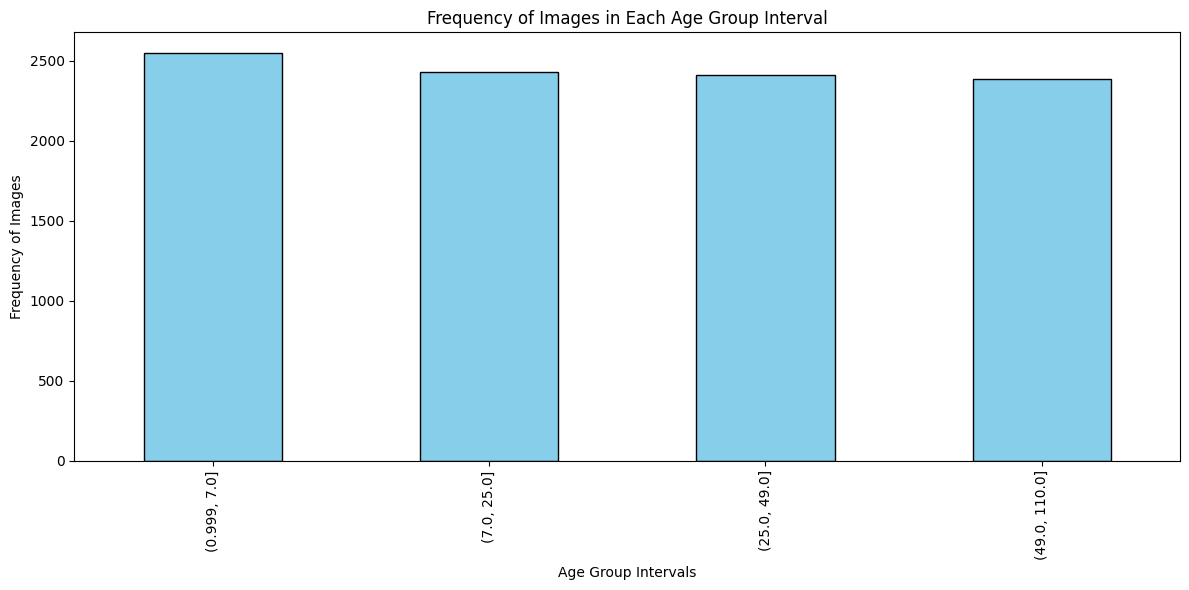

In [7]:
age_group_counts = df['Age_Interval'].value_counts().sort_index()

# Plotting the intervals and their frequencies
plt.figure(figsize=(12, 6))
age_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Set labels and title
plt.xlabel("Age Group Intervals")
plt.ylabel("Frequency of Images")
plt.title("Frequency of Images in Each Age Group Interval")

interval_counts = df['Age_Group'].value_counts().sort_index()
interval_labels = [f"{int(interval)}" for interval in interval_counts.index]

plt.tight_layout()
plt.show()

In [8]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os


transform_pipeline = transforms.Compose([
    transforms.ToTensor(),                     # Convert image to tensor
    # transforms.ToPILImage(),                   # Convert OpenCV image (NumPy array) to PIL format
    transforms.RandomHorizontalFlip(p=0.5),    # 50% chance of horizontal flip
    transforms.RandomRotation(30),             # Random rotation within ±30 degrees
    transforms.Resize((224, 224)),             # Resize to desired input size (224x224 here)
    # transforms.Normalize([0.5], [0.5])         # Normalize; mean and std of 0.5 for grayscale
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter(brightness=0.1, contrast=0.1)
])

In [9]:
def test_processing(df):
    brightImages = []
    smallImages = []
    dullImages = []
    
    blist = []
    varList = []
    for idx in range(len(df)):
        img_path = df.iloc[idx]['image_path']
        img_path = os.path.join(img_path)
        label = df.iloc[idx]['Age_Group']  # Age group label for classification

        image = Image.open(img_path)
        img_array = np.array(image)

        brightness = np.mean(img_array)
        blist.append(brightness)
        if brightness < 50 or brightness > 225:  
            brightImages.append(idx)

        if img_array.shape[0] < 50 or img_array.shape[1] < 50:  # Example minimum size
            smallImages.append(idx)
            
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        variance = cv2.Laplacian(gray, cv2.CV_64F).var()
        varList.append(variance)
        if variance < 22.814826998125:
            dullImages.append(idx)
            
    
    print(brightImages)
    print(smallImages)
    print(dullImages)
    return blist, varList, dullImages
            
            
blist, varlist, dullImages = test_processing(df)



[1249, 1329, 1812, 2927, 3236, 4588, 4699, 4717, 6159, 6942, 7005, 7125, 7752]
[]
[0, 7, 8, 10, 11, 13, 17, 20, 25, 28, 31, 32, 33, 34, 35, 38, 40, 43, 44, 45, 48, 50, 56, 57, 61, 64, 84, 90, 98, 105, 110, 112, 114, 116, 118, 121, 123, 128, 142, 151, 156, 158, 161, 163, 164, 167, 170, 171, 179, 180, 182, 194, 202, 208, 221, 229, 230, 231, 232, 240, 249, 262, 273, 288, 293, 295, 298, 302, 313, 319, 321, 328, 342, 347, 353, 355, 357, 364, 373, 381, 382, 383, 385, 399, 409, 413, 421, 430, 431, 436, 438, 442, 445, 457, 466, 473, 489, 501, 504, 505, 508, 513, 517, 526, 532, 536, 547, 549, 550, 551, 565, 569, 581, 582, 593, 594, 599, 604, 608, 617, 622, 623, 629, 640, 644, 647, 651, 656, 657, 660, 666, 667, 673, 674, 677, 685, 686, 693, 695, 704, 710, 713, 725, 726, 728, 729, 750, 753, 754, 755, 757, 758, 770, 772, 788, 789, 793, 799, 826, 833, 853, 859, 861, 865, 869, 878, 879, 880, 884, 885, 891, 902, 907, 912, 914, 915, 923, 927, 932, 933, 934, 941, 956, 973, 976, 987, 992, 995, 999, 1003

In [10]:

#  brightness
print("Mean Brightness: " + str(np.mean(blist)))
print("Minimum Brightness: " + str(np.min(blist)))
print("Maximum Brightness: " + str(np.max(blist)))
print("Median Brightness: " + str(np.median(blist)))

Q1_brightness = np.percentile(blist, 25)
Q3_brightness = np.percentile(blist, 75)
print("First Quartile (Q1) Brightness: " + str(Q1_brightness))
print("Third Quartile (Q3) Brightness: " + str(Q3_brightness))

print ("---------------------------------------------------------------")
# variance
print("Mean Variance: " + str(np.mean(varlist)))
print("Minimum Variance: " + str(np.min(varlist)))
print("Maximum Variance: " + str(np.max(varlist)))
print("Median Variance: " + str(np.median(varlist)))

Q1_variance = np.percentile(varlist, 25)
Q3_variance = np.percentile(varlist, 75)
print("First Quartile (Q1) Variance: " + str(Q1_variance))
print("Third Quartile (Q3) Variance: " + str(Q3_variance))

Mean Brightness: 131.10234516772346
Minimum Brightness: 34.64850833333333
Maximum Brightness: 239.409775
Median Brightness: 130.06289583333336
First Quartile (Q1) Brightness: 110.6769
Third Quartile (Q3) Brightness: 150.6685875
---------------------------------------------------------------
Mean Variance: 87.78310343591954
Minimum Variance: 4.020422824375
Maximum Variance: 4732.489427777499
Median Variance: 41.339805423437504
First Quartile (Q1) Variance: 22.814826998125
Third Quartile (Q3) Variance: 92.109335073125


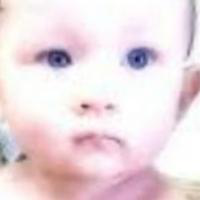

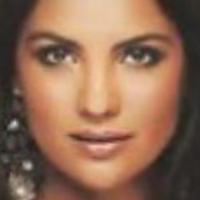

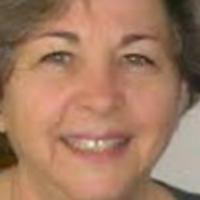

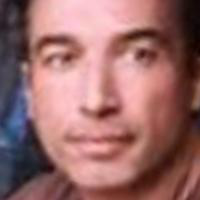

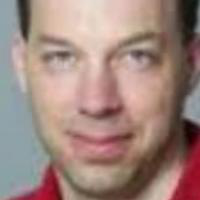

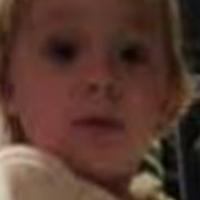

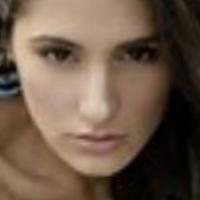

In [11]:
display(Image.open(df.iloc[1812]['image_path']))
display(Image.open(df.iloc[3216]['image_path']))


display(Image.open(df.iloc[0]['image_path']))
display(Image.open(df.iloc[9236]['image_path']))
display(Image.open(df.iloc[8612]['image_path']))
display(Image.open(df.iloc[6745]['image_path']))
display(Image.open(df.iloc[7016]['image_path']))




In [12]:

model = models.vgg16(pretrained=True)


num_classes = 5

# model.classifier[6] = nn.Linear(4096, num_classes)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 188MB/s]  


In [13]:

class facialAge(Dataset):
    def __init__(self, df, transform=None, preprocess=None):
        self.df = df
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        img_path = os.path.join(img_path)
        label = self.df.iloc[idx]['Age_Group']  # Age group label for classification

        image = Image.open(img_path)
        if self.preprocess:
            image = self.preprocess(image)
        if self.transform:
            image = self.transform(image)

        return image, label

    
    
train_df, test_df = train_test_split(df, test_size=0.2, random_state=21)

train_dataset = facialAge(train_df, transform_pipeline)
test_dataset = facialAge(test_df, transform_pipeline)

train_df

,image_path,image_name,age,Age_Group,Age_Interval
6508,/kaggle/input/facial-age/face_age/011/3280.png,3280.png,11,1,"(7.0, 25.0]"
5595,/kaggle/input/facial-age/face_age/066/4167.png,4167.png,66,3,"(49.0, 110.0]"
6565,/kaggle/input/facial-age/face_age/004/8794.png,8794.png,4,0,"(0.999, 7.0]"
279,/kaggle/input/facial-age/face_age/053/8225.png,8225.png,53,3,"(49.0, 110.0]"
4218,/kaggle/input/facial-age/face_age/034/6673.png,6673.png,34,2,"(25.0, 49.0]"
...,...,...,...,...,...
9336,/kaggle/input/facial-age/face_age/038/5783.png,5783.png,38,2,"(25.0, 49.0]"
48,/kaggle/input/facial-age/face_age/057/2579.png,2579.png,57,3,"(49.0, 110.0]"
8964,/kaggle/input/facial-age/face_age/010/6241.png,6241.png,10,1,"(7.0, 25.0]"
5944,/kaggle/input/facial-age/face_age/002/955.png,955.png,2,0,"(0.999, 7.0]"


In [17]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

import torch
import torch.optim as optim

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
device ='cuda'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in dataloader:
        images, labels = batch  # Unpack images and labels
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")


Epoch [1/10], Loss: 0.8753
Epoch [2/10], Loss: 0.9324
Epoch [3/10], Loss: 0.8486
Epoch [4/10], Loss: 0.8350
Epoch [5/10], Loss: 0.8029
Epoch [6/10], Loss: 0.8098
Epoch [7/10], Loss: 0.8621
Epoch [8/10], Loss: 0.7931
Epoch [9/10], Loss: 0.7777
Epoch [10/10], Loss: 0.8831


In [20]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support


test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

model.eval()

# Initialize variables to track performance
correct = 0
total = 0
test_loss = 0.0

all_labels = []
all_predictions = []

# Disable gradient computation for testing
with torch.no_grad():
    for batch in test_dataloader:  # Assuming test_dataloader is your DataLoader for the test set
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predicted class by taking the class with the highest score
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
       
        # Append to lists (convert to CPU and detach from computation graph)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate average loss and accuracy
average_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total

print(f'Test Loss: {average_test_loss:.4f}, Accuracy: {accuracy:.2f}%')





conf_matrix = confusion_matrix(all_labels, all_predictions)



precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_predictions)



print("Confusion Matrix:\n", conf_matrix)

print("\nPrecision per class:", precision)

print("Recall per class:", recall)

print("F1-score per class:", f1_score)

print("Samples per class:", support)

Test Loss: 0.7801, Accuracy: 65.70%
Confusion Matrix:
 [[464  40   7   3]
 [ 75 300  81  27]
 [ 16 155 231  81]
 [ 12  61 113 290]]

Precision per class: [0.81834215 0.53956835 0.53472222 0.72319202]
Recall per class: [0.90272374 0.62111801 0.47826087 0.6092437 ]
F1-score per class: [0.85846438 0.57747834 0.50491803 0.6613455 ]
Samples per class: [514 483 483 476]


In [ ]:
torch.save(model.state_dict(), 'vgg-16-facial-age.pth')

In [ ]:
features = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        outputs = feature_extractor(images)
        features.append(outputs.view(outputs.size(0), -1).cpu())
        labels.append(label.cpu())

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.figure(figsize=(8, 8))
for label in set(labels):
    plt.scatter(
        reduced_features[labels == label, 0],
        reduced_features[labels == label, 1],
        label=str(label)
    )
plt.legend()
plt.title("t-SNE Visualization of DenseNet Features")
plt.show()